In [1]:
# Running on GPU?
import setGPU

setGPU: Setting GPU to: 2


Imports

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

# Set a random seed to reproduce the results
rng = np.random.RandomState(0)

Using TensorFlow backend.


In [3]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

color_palette = ["#F44336", "#9C27B0", "#3F51B5", "#03A9F4", "#009688",
                 "#8BC34A", "#FFC107", "#FF5722", "#9E9E9E"]

Define those yourself if you want to use your own data

In [4]:
#data_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"
#labels_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"

data_directory = "../data"
labels_directory = "../data"

# Drift Tubes Digi Occupancy Anomaly Problem

Reliable data quality monitoring is a key asset to deliver high-quality data for physics analysis for any modern large-scale High Energy Physics experiment. The current paradigm of the quality assessment in the Compact Muon Solenoid collaboration is based on the scrutiny of a large number of histograms by detector experts comparing them with a reference. This work investigates whether recent progress in Deep Learning techniques could contribute to the automation of this process allowing the check of large volumes of data in real-time and improving the ability to detect unexpected failures. Precisely, we have evaluated the performance of Convolutional Neural Networks in spotting problems with Compact Muon Solenoid drift tube muon detectors.

Load occupancy data to the dataframe:

In [5]:
runs = [273158, 273730, 274388, 274422, 274968, 274969, 275310, 275311,
        275847, 275890, 276244, 276283, 276384, 276587, 276775, 276776,
        276950, 278509, 278820, 278822, 279694, 279766, 279794, 280018,
        281693, 281727, 281976, 282735, 282814, 276582, 272011, 272012,
        272014, 272017, 272021, 272774, 284044, 284043, 284042, 284041]

drift_tubes_layers = pd.DataFrame()

for run in runs:
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);

In [6]:
# Convert string data to list
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)

Append score from labels data file:

In [7]:
labels_frame = pd.read_csv(("%s/labels.csv" % labels_directory),
                           names=["wheel", "station", "sector", "run", "layer", "score"])

def apply_score(layer):
    score = labels_frame[(labels_frame.wheel == layer.wheel) &
                         (labels_frame.station == layer.station) &
                         (labels_frame.sector == layer.sector) &
                         (labels_frame.run == layer.run) &
                         (labels_frame.layer == layer.layer)].score.values
    if not len(score):
        return np.nan

    return score[0]

drift_tubes_layers["score"] = drift_tubes_layers.apply(apply_score, axis=1);

## Preprocessing

Use median polling to remove extreme values (remove noise):

In [8]:
SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

Use bilinear interpolation to resize all the data samples to match the smallest:

In [9]:
print("Minimum raw length: % s" % min(drift_tubes_layers["content"].apply(len)))
print("Maximum raw length: % s" % max(drift_tubes_layers["content"].apply(len)))
print("Minimum smoothed length: % s" % min(drift_tubes_layers["content_smoothed"].apply(len)))
print("Maximum smoothed length: % s" % max(drift_tubes_layers["content_smoothed"].apply(len)))

Minimum raw length: 47
Maximum raw length: 96
Minimum smoothed length: 45
Maximum smoothed length: 94


In [10]:
def resize_occupancy(layer):
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp='bilinear', mode="F")

SAMPLE_SIZE = min(drift_tubes_layers["content"].apply(len))
drift_tubes_layers["content_resized"] = drift_tubes_layers["content"].apply(resize_occupancy)

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_layers["content_smoothed_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

Scale input to account for integration time and beam intensity:

In [11]:
def scale_occupancy(layer):
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

drift_tubes_layers["content_scaled"] = drift_tubes_layers["content_resized"].apply(scale_occupancy)
drift_tubes_layers["content_smoothed_scaled"] = drift_tubes_layers["content_smoothed_resized"].apply(scale_occupancy)

### Visualize preprocessing steps

Combine per layer data to per chamber data:

In [12]:
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):
                chamber = labels_frame[(labels_frame.run == run) &
                                       (labels_frame.wheel == wheel) &
                                       (labels_frame.station == station) &
                                       (labels_frame.sector == sector)]
                if chamber.empty:
                    continue

                data = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                          (drift_tubes_layers.wheel == wheel) &
                                          (drift_tubes_layers.station == station) &
                                          (drift_tubes_layers.sector == sector)].sort_values('layer',
                                                                                             ascending=1)
    
                occupancy_raw = [_ for _ in data['content']]
                occupancy_smoothed = [_ for _ in data['content_smoothed']]
                occupancy_resized = [_ for _ in data['content_resized']]
                occupancy_smoothed_resized = [_.tolist() for _ in data["content_smoothed_resized"]]
                occupancy_scaled = [_ for _ in data["content_scaled"]]
                occupancy_smoothed_scaled = [_.tolist() for _ in data["content_smoothed_scaled"]]

                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                
                for index, layer in enumerate(occupancy_raw):
                    foo = np.empty(extended_size_raw - len(layer), float)
                    foo.fill(np.nan)
                    layer = np.append(layer, foo)
                    occupancy_raw[index] = layer
                    
                for index, layer in enumerate(occupancy_smoothed):
                    foo = np.empty(extended_size_smoothed - len(layer), float)
                    foo.fill(np.nan)
                    layer = np.append(layer, foo)
                    occupancy_smoothed[index] = layer

                score = sum(chamber.score.values)
                
                data = {'run': run,
                        'wheel': wheel,
                        'station': station,
                        'sector': sector,
                        'score': score,
                        'content_raw': np.concatenate(occupancy_raw).reshape(len(data), extended_size_raw),
                        'content_smoothed': np.concatenate(occupancy_smoothed).reshape(len(data), extended_size_smoothed),
                        'content_resized': np.reshape(occupancy_resized, (len(data), 47)),
                        'content_smoothed_resized': np.reshape(occupancy_smoothed_resized, (len(data), 45)),
                        'content_scaled': np.reshape(occupancy_scaled, (len(data), 47)),
                        'content_smoothed_scaled': np.reshape(occupancy_smoothed_scaled, (len(data), 45))}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data), ignore_index=True)

In [13]:
def plot_occupancy_hitmap(data, title):
    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(['1','5','9'])
    ax.set_yticks([0, 4, 8])
    
    plt.xlabel("Channel")
    plt.ylabel("Layer")
    
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title, loc='right')   
    plt.show();
    
def get_title(title, show):
    return ("%s Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show, smoothed):
    if smoothed:
        plot_occupancy_hitmap(show.content_smoothed, get_title("Smoothed", show))
        plot_occupancy_hitmap(show.content_smoothed_resized, get_title("Reshaped", show))
        plot_occupancy_hitmap(show.content_smoothed_scaled, get_title("Scaled", show)) 

    else:
        plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))
        plot_occupancy_hitmap(show.content_resized, get_title("Reshaped", show))
        plot_occupancy_hitmap(show.content_scaled, get_title("Scaled", show))

Example of preprocessing pipeline for <b>chamber without problems</b>:

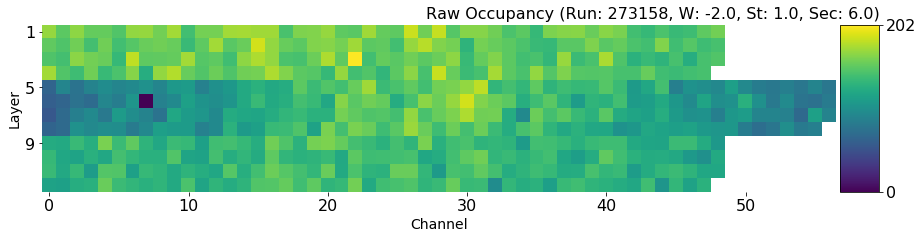

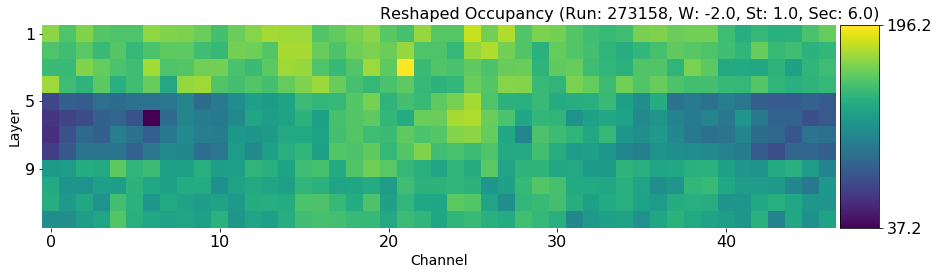

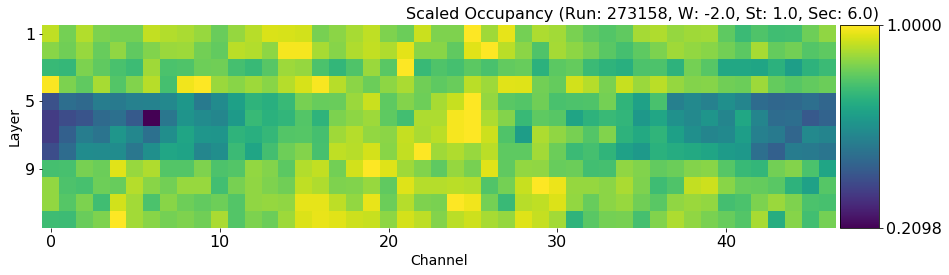

In [14]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[0], False)

Example of preprocessing pipeline for <b>chamber with one faulty layer</b>:

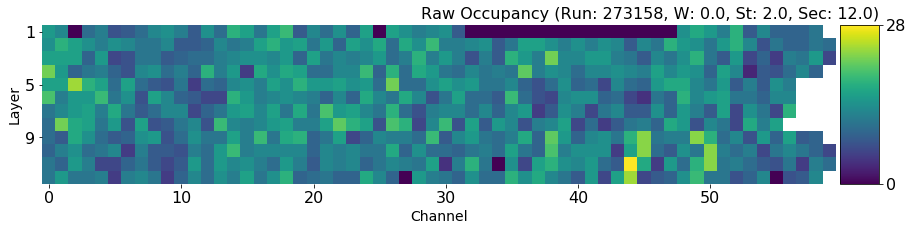

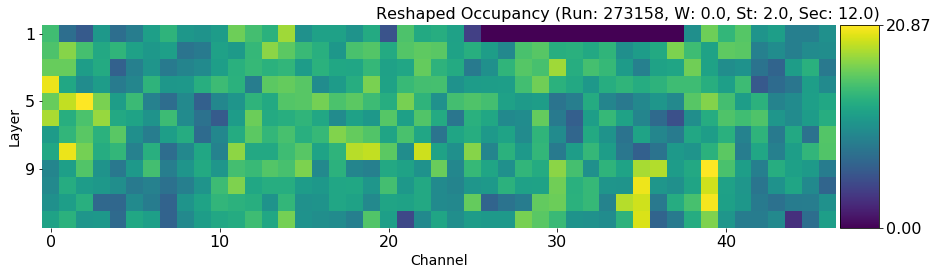

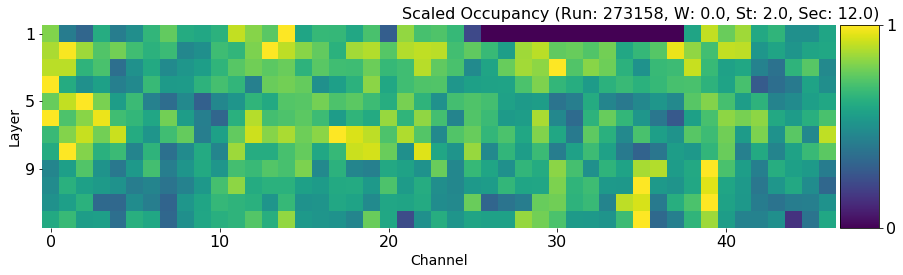

In [15]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 11].iloc[0], False)

Example of preprocessing pipeline for <b>chamber with twelve faulty layer</b>:

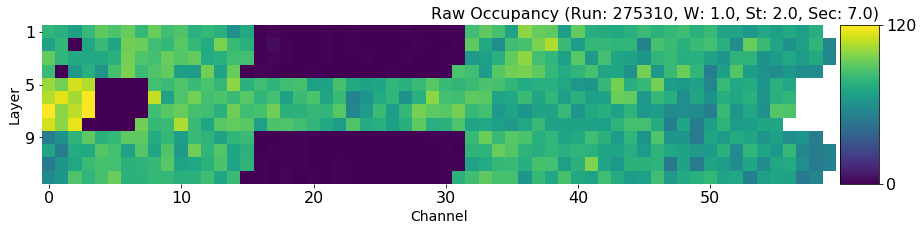

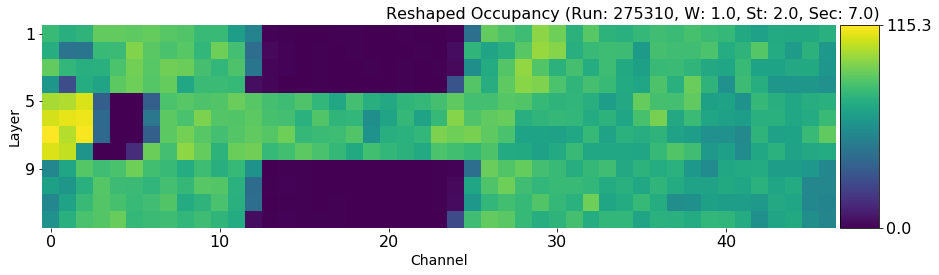

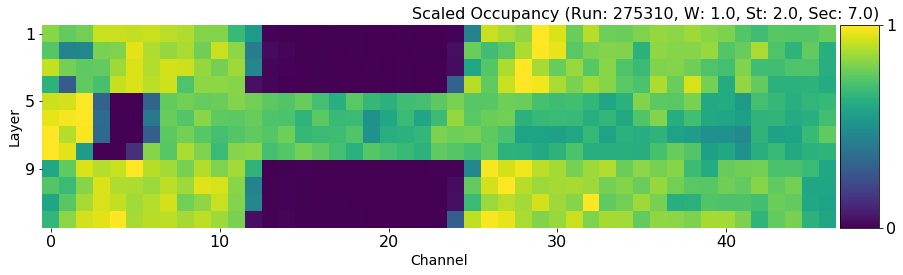

In [16]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[0], False)

Example of <b>alternative</b> preprocessing (with median polling) pipeline for <b>chamber without problems</b>:

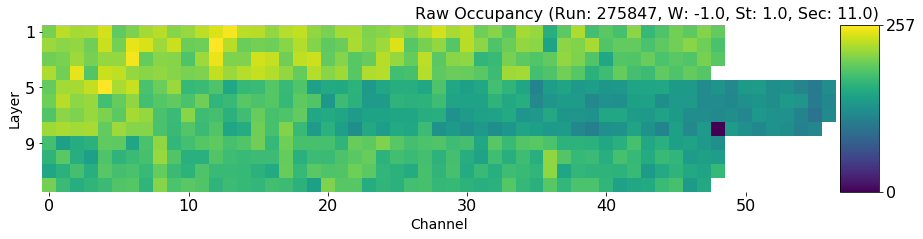

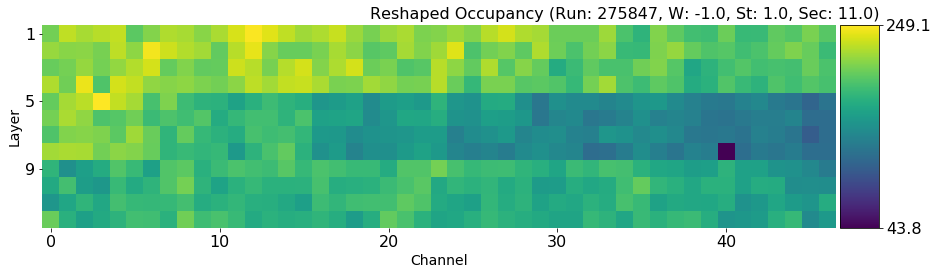

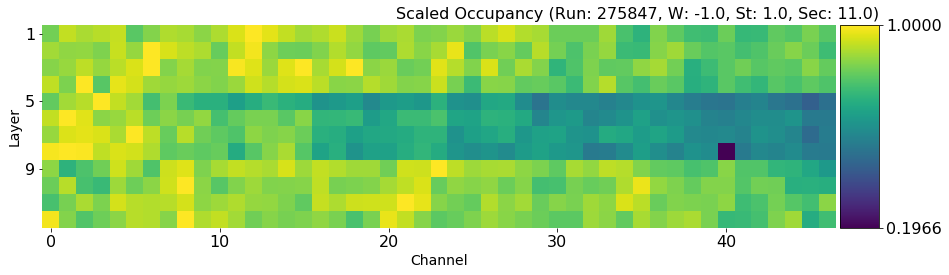

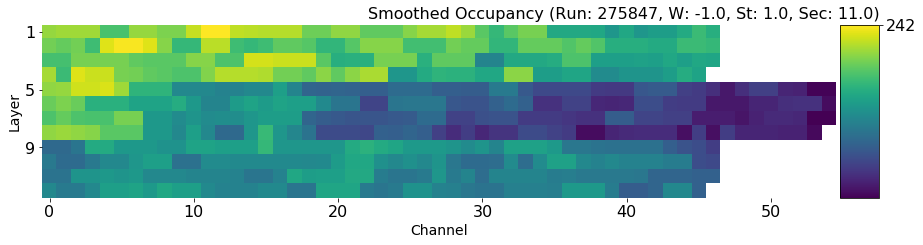

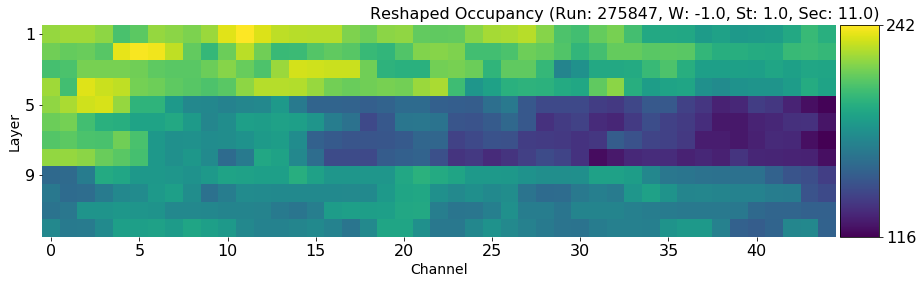

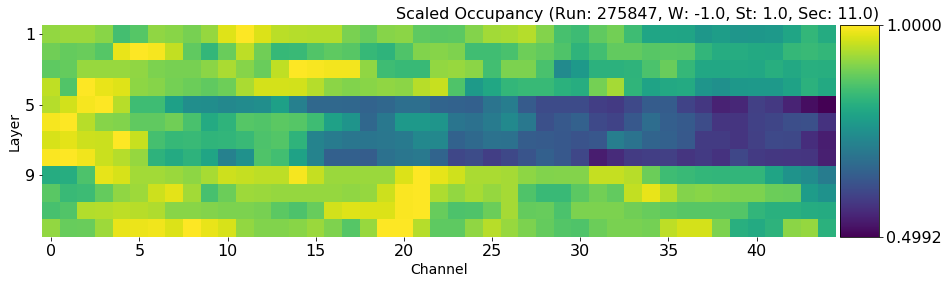

In [17]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[87], False)
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[87], True)

## Baseline

### Currently implemented tests

In [18]:
def threshold_test(content):
    return (float(len(np.where(content == 0)[0])) / len(np.where(~np.isnan(content))[0]))

drift_tubes_chambers["treshold"] = drift_tubes_chambers["content_raw"].apply(threshold_test)

Performace of the current tests wrt. number of faulty layers:

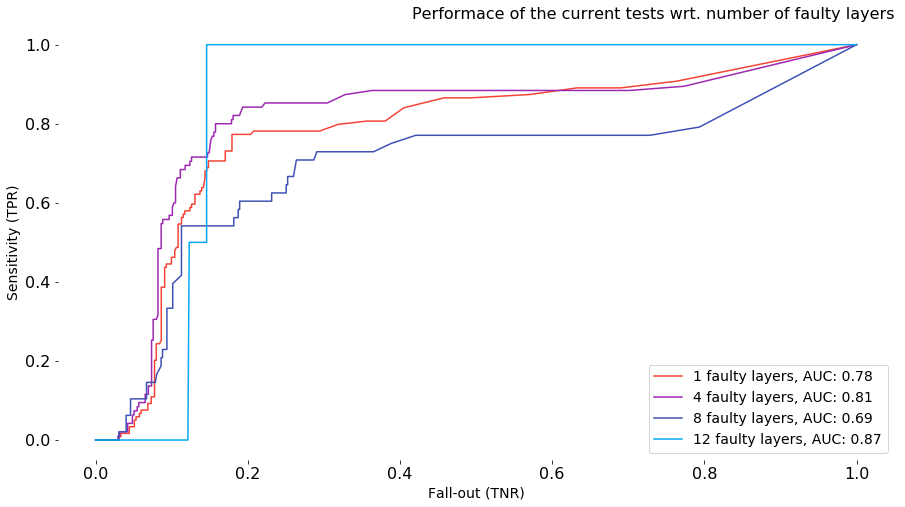

In [19]:
fig, ax = plt.subplots()

for x, faulty_layers in enumerate([1,4,8,12]):
    score = 2*(drift_tubes_chambers["score"] <= (12 - faulty_layers)) - 1
    false_positive_rate, true_positive_rate, _ = roc_curve(score, drift_tubes_chambers["treshold"])

    plt.plot(false_positive_rate, true_positive_rate, color_palette[x], linewidth=1.5,
             label=('%s faulty layers, AUC: %s' % (faulty_layers,
                                     round(auc(false_positive_rate, true_positive_rate), 2))))

plt.title("Performace of the current tests wrt. number of faulty layers", loc='right')           
plt.legend(loc="best")
plt.ylabel("Sensitivity (TPR)")
plt.xlabel("Fall-out (TNR)")
plt.show();

### Split the dataset to be able to use supervised learning:

In [20]:
def change_score(score):
    return -(2*score-1)

drift_tubes_layers['score'] = drift_tubes_layers['score'].apply(change_score)

drift_tubes_layers_scored = drift_tubes_layers[~np.isnan(drift_tubes_layers.score)]

anomalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == 1]
normalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

612 faults and 5668 good samples. In total: 6280.
Number of anomalies in the train set: 123
Number of normal in the train set: 1134


### Baseline simple alternative tests

In [21]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score, color in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, color, linewidth=1.5,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o', color=working_point[2],
                 label="CNN working point")
    plt.title("ROC", loc='right')
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

In [22]:
def sobel(content):
    return max(abs(ndimage.sobel(content)[0]))

def variance(content):
    return np.var(content)
    
layers_test["sobel_score"] = layers_test["content_smoothed_scaled"].apply(sobel)
layers_test["variance_score"] = layers_test["content_smoothed_scaled"].apply(variance)

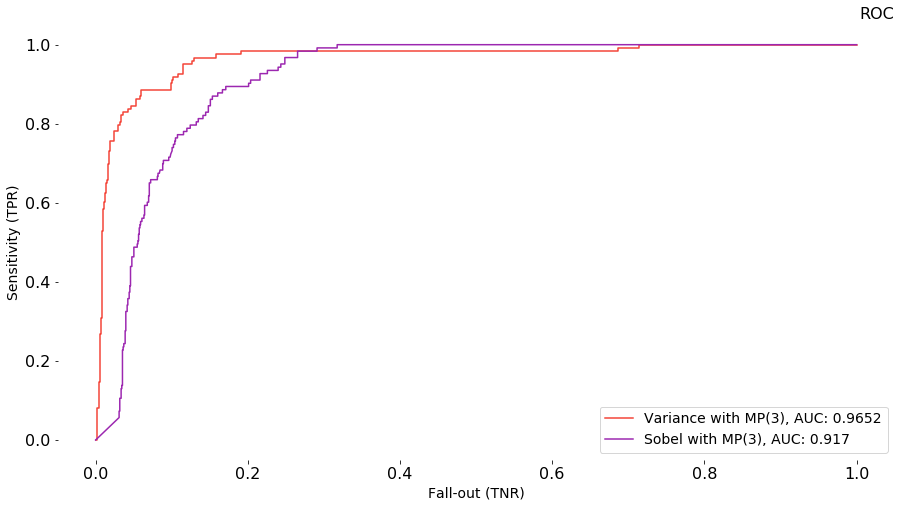

In [23]:
get_roc_curve(layers_test,[('Variance with MP(3)', 'variance_score', color_palette[0]),
                           ('Sobel with MP(3)', 'sobel_score', color_palette[1])])

### Benchmarking SVM and IF:

Cross validate model selection using Stratified5Fold and GridSearchCV:

In [24]:
def cross_validation_spit(train_X, train_y, clf_i, param_grid, validation=None):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    return clf.best_estimator_

In [25]:
# This may take some time...
param_grid = [{'nu': np.array(range(1, 10, 1))/10.0,
               'gamma': ['auto', 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['linear', 'rbf']}]

svmclf = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                               layers_train["score"],
                               svm.OneClassSVM(random_state=rng),
                               param_grid)

In [26]:
# This may take some time...
param_grid = [{'max_samples': [100, 1000],
               'n_estimators': [10, 100],
               'contamination': np.array(range(6, 13, 1))/100.0}]

ifclf = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                               layers_train["score"],
                               IsolationForest(random_state=rng),
                               param_grid)

In [27]:
layers_test['svm_score'] = -svmclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))
layers_test['if_score'] = -ifclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))

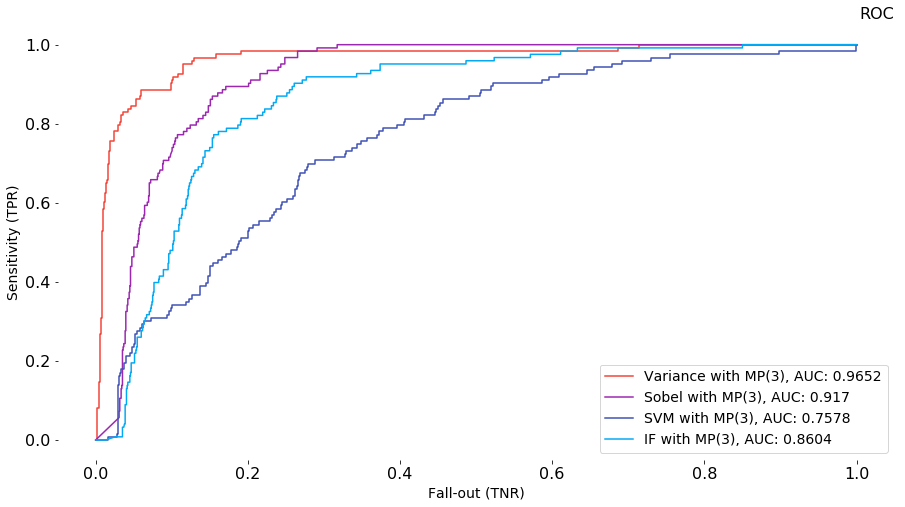

In [28]:
get_roc_curve(layers_test,[('Variance with MP(3)', 'variance_score', color_palette[0]),
                           ('Sobel with MP(3)', 'sobel_score', color_palette[1]),
                           ('SVM with MP(3)', 'svm_score', color_palette[2]),
                           ('IF with MP(3)', 'if_score', color_palette[3])])

### Train and test Neural Networks:

Start Keras session:

In [29]:
sess = tf.Session()
K.set_session(sess)

Generate CNN input:

In [30]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def cnn_generate_input():
    return (np.array(np.concatenate(layers_train.content_scaled.values)).reshape(-1, 47, 1),
            np.concatenate(layers_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 47, 1))

(train_x, train_y, test_x) = cnn_generate_input()

Calculate weights for different classes:

In [31]:
classes_count = sum(train_y)
class_weight = {0: classes_count[1], 1: classes_count[0]}

Define networks:

In [32]:
def neural_network():
    model = Sequential()
    model.add(InputLayer((47, 1), name='input_nn'))
    model.add(Flatten(name="flatten_perceptron"))
    model.add(Dense(16, activation='relu', name="dense_nn"))
    model.add(Dense(2, activation='softmax', name='output_nn'))
    return model

def convolutional_neural_network():
    model = Sequential()
    model.add(InputLayer((47, 1), name='input'))
    model.add(Conv1D(10, 3, strides=1, padding='valid', activation='relu', name="convolution"))
    model.add(MaxPooling1D(pool_size=5, strides=5, padding='valid', name="polling"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(16, activation='relu', name="dense"))
    model.add(Dense(2, activation='softmax', name='output'))
    return model

def convolutional_autoencoder():
    model = Sequential()
    model.add(InputLayer((47, 1), name='input'))
    model.add(Conv1D(4, 3, strides=1, padding='valid', activation='relu', name="convolution1"))
    model.add(AveragePooling1D(pool_size=5, strides=5, padding='valid', name="polling1"))
    model.add(Conv1D(8, 3, strides=3, padding='valid', activation='relu', name="convolution2"))
    model.add(AveragePooling1D(pool_size=3, strides=1, padding='valid', name="polling2"))    
    
    model.add(UpSampling1D(8, name="upsampling1"))
    model.add(Conv1D(8, 3, strides=1, padding='same', activation='relu', name="convolution3"))
    model.add(UpSampling1D(6, name="upsampling2"))
    model.add(Conv1D(1, 2, strides=1, padding='valid', activation='relu', name="convolution4"))
    return model

nn = neural_network()
cnn = convolutional_neural_network()
cae = convolutional_autoencoder()
nn.summary()
cnn.summary()
cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_nn (InputLayer)        (None, 47, 1)             0         
_________________________________________________________________
flatten_perceptron (Flatten) (None, 47)                0         
_________________________________________________________________
dense_nn (Dense)             (None, 16)                768       
_________________________________________________________________
output_nn (Dense)            (None, 2)                 34        
Total params: 802
Trainable params: 802
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 47, 1)             0         
_________________________________________________________________
convolution 

Train neural networks:

In [33]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, class_weight=None):
    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(('../model_keras/%s.h5' % name),
                                          monitor='loss',
                                          verbose=False,
                                          save_best_only=True,
                                          mode='min')
    
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     callbacks=[early_stopper, checkpoint_callback])

history_cae = train_nn(cae,
                       train_x,
                       train_x,
                       len(train_x),
                       keras.losses.mse,
                       "cae")
history_nn = train_nn(nn,
                      train_x,
                      train_y,
                      len(train_x),
                      keras.losses.categorical_crossentropy,
                      "neural",
                      class_weight)
history_cnn = train_nn(cnn,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "convolution",
                       class_weight)

Epoch 00601: early stopping


Plot loss vs. epoch:

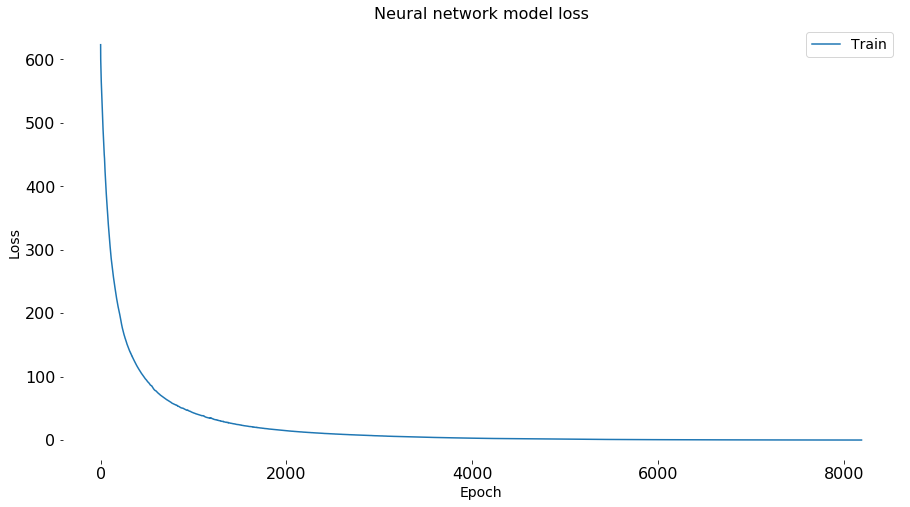

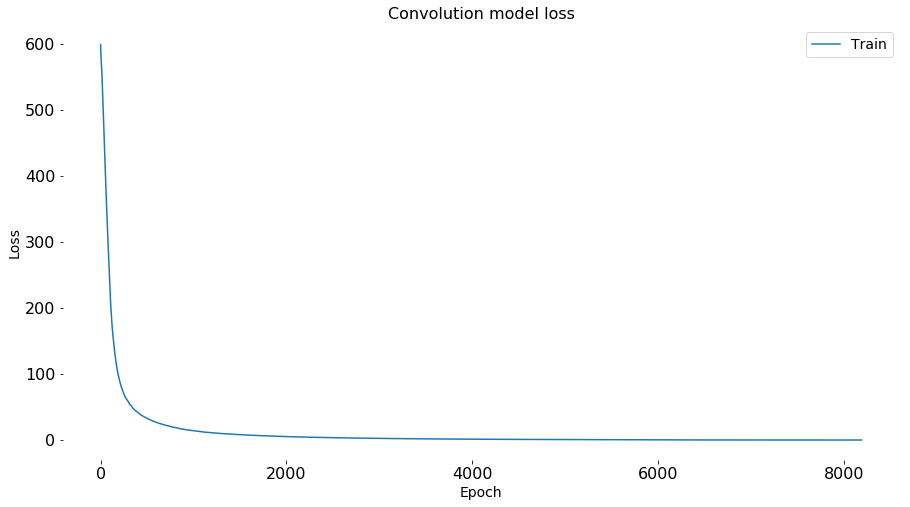

In [34]:
def plot_loss(data, title):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data['loss'])
    plt.legend(['Train'], loc='upper right')
    plt.show();

plot_loss(history_nn.history, "Neural network model loss")
plot_loss(history_cnn.history, "Convolution model loss")

Reload models from saved:

In [35]:
nn_model = load_model('../model_keras/neural.h5')
cae_model = load_model('../model_keras/cae.h5')
cnn_model = load_model('../model_keras/convolution.h5')

Export models as .pb:

In [36]:
print(cnn_model.inputs)
print(cnn_model.output)

[<tf.Tensor 'input_3:0' shape=(?, 47, 1) dtype=float32>]
Tensor("output_1/Softmax:0", shape=(?, 2), dtype=float32)


In [37]:
# builder = tf.saved_model.builder.SavedModelBuilder("../model")
# builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
# builder.save()

In [38]:
# #https://stackoverflow.com/questions/45466020

# def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
#     """
#     Freezes the state of a session into a prunned computation graph.

#     Creates a new computation graph where variable nodes are replaced by
#     constants taking their current value in the session. The new graph will be
#     prunned so subgraphs that are not neccesary to compute the requested
#     outputs are removed.
#     @param session The TensorFlow session to be frozen.
#     @param keep_var_names A list of variable names that should not be frozen,
#                           or None to freeze all the variables in the graph.
#     @param output_names Names of the relevant graph outputs.
#     @param clear_devices Remove the device directives from the graph for better portability.
#     @return The frozen graph definition.
#     """
#     from tensorflow.python.framework.graph_util import convert_variables_to_constants
#     graph = session.graph
#     with graph.as_default():
#         freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
#         output_names = output_names or []
#         output_names += [v.op.name for v in tf.global_variables()]
#         input_graph_def = graph.as_graph_def()
#         if clear_devices:
#             for node in input_graph_def.node:
#                 node.device = ""
#         frozen_graph = convert_variables_to_constants(session, input_graph_def,
#                                                       output_names, freeze_var_names)
#         return frozen_graph
    
# frozen_graph = freeze_session(K.get_session(), output_names=[cnn_model.output.op.name])
# tf.train.write_graph(frozen_graph, "../model", "cnn4dt.pb", as_text=False)

Calculate score for trained networks:

In [39]:
layers_test['cae_score'] = -cae_model.predict(np.array(test_x))[:, 1]
layers_test['neural_score'] = nn_model.predict(np.array(test_x))[:, 1]
layers_test['convolution_score'] = cnn_model.predict(np.array(test_x))[:, 1]

This is how the ROC curve for the model looks like:

In [40]:
def benchmark(y_true, y_score):
    y_pred = 2*(y_score > 0.5)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)
    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)
    return sensitivity, specificity
    
sensitivity_cnn, specificity_cnn = benchmark(layers_test['score'], layers_test['convolution_score'])

Model accuracy: 0.996
Model sensitivity: 0.9837
Model specificity: 0.9974


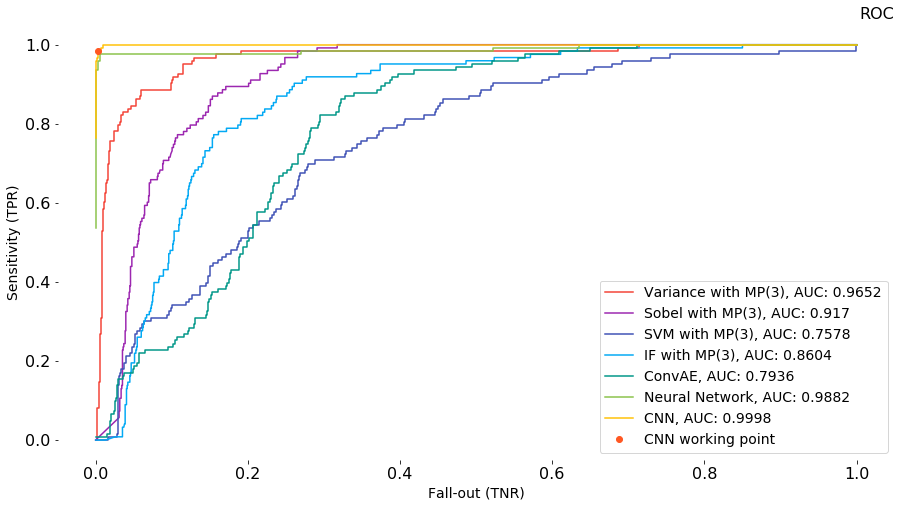

In [41]:
get_roc_curve(layers_test,
              [('Variance with MP(3)', 'variance_score', color_palette[0]),
               ('Sobel with MP(3)', 'sobel_score', color_palette[1]),
               ('SVM with MP(3)', 'svm_score', color_palette[2]),
               ('IF with MP(3)', 'if_score', color_palette[3]),
               ('ConvAE', 'cae_score', color_palette[4]),
               ('Neural Network', 'neural_score', color_palette[5]),
               ('CNN', 'convolution_score', color_palette[6])],
              (specificity_cnn, sensitivity_cnn, color_palette[7]))

And this is distribution of scores:

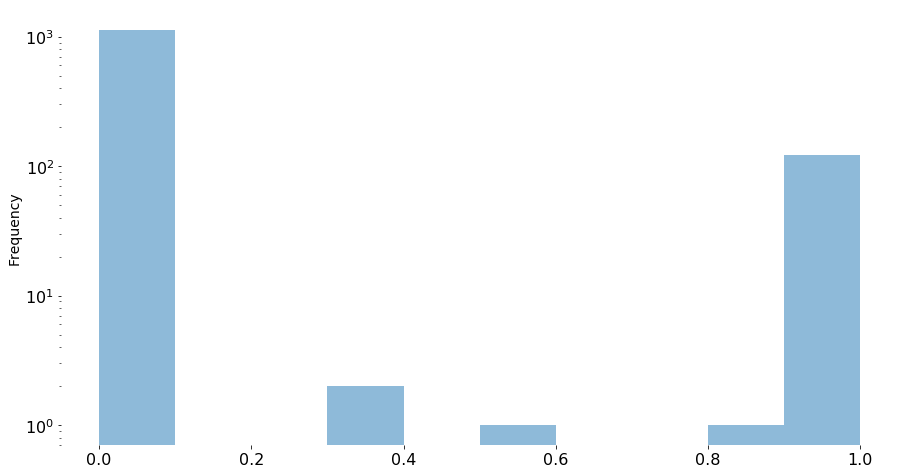

In [42]:
layers_test['convolution_score'].plot.hist(alpha=0.5, bins=10, logy=True)
plt.show();